In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
import requests
import json
from urllib.parse import urlencode
warnings.filterwarnings("ignore")

In [2]:
with open("C:/Users/Bora/Desktop/api.txt") as api:
    key=api.read()



In [3]:
import yfinance as yf 


In [4]:
params = {
    'series': "TP.DK.USD.S.YTL",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

usd = formatted_response['items']
usd = pd.DataFrame(usd)


usd = usd.drop(columns=['UNIXTIME','Tarih'])
usd.columns = ['USD/TL']
usd['USD/TL'] = pd.to_numeric(usd['USD/TL'])
usd=usd.set_index(pd.date_range(start="2006-01-01",freq="D",periods=len(usd)))
usd=usd.dropna()
usd

,USD/TL
2006-01-02,1.3483
2006-01-03,1.3506
2006-01-04,1.3484
2006-01-05,1.3381
2006-01-06,1.3362
...,...
2024-07-19,33.0985
2024-07-22,33.0637
2024-07-23,33.0035
2024-07-24,32.9398


In [5]:
params = {
    'series': "TP.FE.OKTG01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf = formatted_response['items']
enf = pd.DataFrame(enf)


enf = enf.drop(columns=['UNIXTIME','Tarih'])
enf.columns = ['TÜFE']
enf['TÜFE'] = pd.to_numeric(enf['TÜFE'])
enf=enf.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf)))
enf

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2024-02-29,2073.88
2024-03-31,2139.47
2024-04-30,2207.50
2024-05-31,2281.85


In [6]:
params = {
    'series': "TP.PR.ARZ13",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

money = formatted_response['items']
money = pd.DataFrame(money)


money = money.drop(columns=['UNIXTIME','Tarih'])
money.columns = ['Para Arzi']
money['Para Arzi'] = pd.to_numeric(money['Para Arzi'])
money=money.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(money)))
money=money.pct_change()*100
money=money.dropna()
money

,Para Arzi
2006-02-28,2.121748
2006-03-31,2.927613
2006-04-30,1.084694
2006-05-31,9.121170
2006-06-30,1.433197
...,...
2024-03-31,2.396667
2024-04-30,1.982216
2024-05-31,1.859475
2024-06-30,3.106922


In [7]:
params = {
    'series': "TP.PR.ARZ22",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m3 = formatted_response['items']
m3 = pd.DataFrame(m3)


m3 = m3.drop(columns=['UNIXTIME','YEARWEEK'])
m3.columns = ['Tarih','M3']
m3['M3'] = pd.to_numeric(m3['M3'])
m3 = m3.set_index(pd.to_datetime(m3["Tarih"], format="%d-%m-%Y"))
del m3["Tarih"]
m3=m3.pct_change(4)*100
m3=m3.resample('M').last()
m3=m3.dropna()
m3

,M3
Tarih,
2006-02-28,2.204708
2006-03-31,2.711175
2006-04-30,1.323922
2006-05-31,9.308200
2006-06-30,-0.288618
...,...
2024-03-31,2.687835
2024-04-30,2.405048
2024-05-31,3.570039


In [8]:
params = {
    'series': "TP.TIG08",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

issizlik = formatted_response['items']
issizlik = pd.DataFrame(issizlik)


issizlik = issizlik.drop(columns=['UNIXTIME','Tarih'])
issizlik.columns = ['İşsizlik']
issizlik['İşsizlik'] = pd.to_numeric(issizlik['İşsizlik'])
issizlik=issizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(issizlik)))
issizlik=issizlik.dropna()
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2024-01-31,9.0
2024-02-29,8.7
2024-03-31,8.6
2024-04-30,8.5


In [9]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2024-03-31,84.665499
2024-04-30,88.999999
2024-05-31,82.991819


In [10]:
params = {
    'series': "TP.KREDI.L001",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

kredi = formatted_response['items']
kredi = pd.DataFrame(kredi)


kredi = kredi.drop(columns=['UNIXTIME','YEARWEEK'])
kredi.columns = ['Tarih','Kredi']
kredi['Kredi'] = pd.to_numeric(kredi['Kredi'])
kredi = kredi.set_index(pd.to_datetime(kredi["Tarih"], format="%d-%m-%Y"))
del kredi["Tarih"]
kredi=kredi.pct_change(4)*100
kredi=kredi.resample('M').last()
kredi=kredi.dropna()
kredi

,Kredi
Tarih,
2006-02-28,1.559036
2006-03-31,5.768193
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.965727
...,...
2024-03-31,4.108658
2024-04-30,1.832087
2024-05-31,2.996833


In [11]:
params = {
    'series': "TP.APIFON4",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

pfaiz = formatted_response['items']
pfaiz = pd.DataFrame(pfaiz)


pfaiz = pfaiz.drop(columns=['UNIXTIME','Tarih'])
pfaiz.columns = ['Faiz']
pfaiz['Faiz'] = pd.to_numeric(pfaiz['Faiz'])
pfaiz=pfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(pfaiz)))
pfaiz=pfaiz.dropna()
pfaiz

,Faiz
2011-01-31,6.438571
2011-02-28,6.250000
2011-03-31,6.250000
2011-04-30,6.267619
2011-05-31,6.250000
...,...
2024-03-31,47.287619
2024-04-30,51.357222
2024-05-31,50.544545
2024-06-30,50.106471


In [12]:
motorin=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
motorin=motorin.iloc[-1,:]
motorin=pd.DataFrame(motorin[3:])
motorin=motorin.set_index(pd.date_range(start="2005-01-31",periods=len(motorin),freq="M"))
motorin.columns=["Motorin"]
motorin

,Motorin
2005-01-31,1.75
2005-02-28,1.78
2005-03-31,1.87
2005-04-30,1.94
2005-05-31,1.88
...,...
2024-02-29,43.0968
2024-03-31,42.0568
2024-04-30,42.6763
2024-05-31,41.2854


In [13]:
params = {
    'series': "TP.TRY.MT02",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

mfaiz = formatted_response['items']
mfaiz = pd.DataFrame(mfaiz)


mfaiz = mfaiz.drop(columns=['UNIXTIME','Tarih'])
mfaiz.columns = ['Mevduat Faizi']
mfaiz['Mevduat Faizi'] = pd.to_numeric(mfaiz['Mevduat Faizi'])
mfaiz=mfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(mfaiz)))
mfaiz=mfaiz.dropna()
mfaiz

,Mevduat Faizi
2006-01-31,15.913333
2006-02-28,15.760000
2006-03-31,15.330000
2006-04-30,15.175000
2006-05-31,14.925000
...,...
2024-03-31,57.272000
2024-04-30,67.567500
2024-05-31,64.538000
2024-06-30,59.695000


In [14]:
params = {
    'series': "TP.BEK.S01.A.S",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf_belirsizlik = formatted_response['items']
enf_belirsizlik = pd.DataFrame(enf_belirsizlik)


enf_belirsizlik = enf_belirsizlik.drop(columns=['UNIXTIME','Tarih'])
enf_belirsizlik.columns = ['Enflasyon Belirsizliği']
enf_belirsizlik['Enflasyon Belirsizliği'] = pd.to_numeric(enf_belirsizlik['Enflasyon Belirsizliği'])
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf_belirsizlik)))
enf_belirsizlik=enf_belirsizlik.dropna()
enf_belirsizlik

,Enflasyon Belirsizliği
2013-01-31,0.32
2013-02-28,0.22
2013-03-31,0.16
2013-04-30,0.26
2013-05-31,0.29
...,...
2024-03-31,0.64
2024-04-30,0.55
2024-05-31,0.47
2024-06-30,0.48


In [15]:
params = {
    'series': "TP.FG.B01.95",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ito = formatted_response['items']
ito = pd.DataFrame(ito)


ito = ito.drop(columns=['UNIXTIME','Tarih'])
ito.columns = ['İTO']
ito['İTO'] = pd.to_numeric(ito['İTO'])
ito=ito.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ito)))
ito=ito.pct_change()*100
ito=ito.dropna()
ito

,İTO
2006-02-28,1.005528
2006-03-31,0.137253
2006-04-30,2.088936
2006-05-31,1.595826
2006-06-30,-0.100368
...,...
2024-02-29,4.070637
2024-03-31,3.926249
2024-04-30,4.894259
2024-05-31,3.589407


In [16]:
params = {
    'series': "TP.FE.OKTG04",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

tufec = formatted_response['items']
tufec = pd.DataFrame(tufec)


tufec = tufec.drop(columns=['UNIXTIME','Tarih'])
tufec.columns = ['TÜFE C']
tufec['TÜFE C'] = pd.to_numeric(tufec['TÜFE C'])
tufec=tufec.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(tufec)))
tufec=tufec.pct_change()*100
tufec=tufec.shift(1)
tufec=tufec.dropna()
tufec

,TÜFE C
2006-03-31,-1.101304
2006-04-30,-0.368460
2006-05-31,1.857331
2006-06-30,2.622237
2006-07-31,1.344445
...,...
2024-02-29,7.576163
2024-03-31,3.571725
2024-04-30,3.524351
2024-05-31,3.562117


In [17]:
params = {
    'series': "TP.TUFE1YI.T1",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

üfe = formatted_response['items']
üfe = pd.DataFrame(üfe)


üfe = üfe.drop(columns=['UNIXTIME','Tarih'])
üfe.columns = ['ÜFE']
üfe['ÜFE'] = pd.to_numeric(üfe['ÜFE'])
üfe=üfe.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(üfe)))
üfe=üfe.pct_change()*100
üfe=üfe.dropna()
üfe

,ÜFE
2006-02-28,0.256616
2006-03-31,0.247960
2006-04-30,1.938881
2006-05-31,2.770820
2006-06-30,4.021325
...,...
2024-02-29,3.737000
2024-03-31,3.294983
2024-04-30,3.602753
2024-05-31,1.957875


In [18]:
params = {
    'series': "TP.IHRACATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ihracat = formatted_response['items']
ihracat = pd.DataFrame(ihracat)


ihracat = ihracat.drop(columns=['UNIXTIME','Tarih'])
ihracat.columns = ['ÜFE']
ihracat['ÜFE'] = pd.to_numeric(ihracat['ÜFE'])
ihracat=ihracat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ihracat)))
ihracat=ihracat.shift(1)
ihracat=ihracat.dropna()
ihracat=ihracat.pct_change()*100
ihracat

,ÜFE
2013-02-28,NaN
2013-03-31,7.272509
2013-04-30,6.926004
2013-05-31,-4.381315
2013-06-30,5.141469
...,...
2024-01-31,-0.013509
2024-02-29,-12.996120
2024-03-31,5.560892
2024-04-30,7.087821


In [19]:
params = {
    'series': "TP.ITHALATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ithalat = formatted_response['items']
ithalat = pd.DataFrame(ithalat)


ithalat = ithalat.drop(columns=['UNIXTIME','Tarih'])
ithalat.columns = ['ÜFE']
ithalat['ÜFE'] = pd.to_numeric(ithalat['ÜFE'])
ithalat=ithalat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ithalat)))
ithalat=ithalat.shift(1)
ithalat=ithalat.dropna()
ithalat=ithalat.pct_change()*100
ithalat

,ÜFE
2013-02-28,NaN
2013-03-31,3.993020
2013-04-30,4.802567
2013-05-31,11.093906
2013-06-30,0.635134
...,...
2024-01-31,0.410951
2024-02-29,-9.739818
2024-03-31,6.280869
2024-04-30,7.387077


In [20]:
params = {
    'series': "TP.PKAUO.S01.A.U",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

anket = formatted_response['items']
anket = pd.DataFrame(anket)


anket = anket.drop(columns=['UNIXTIME','Tarih'])
anket.columns = ['ÜFE']
anket['ÜFE'] = pd.to_numeric(anket['ÜFE'])
anket=anket.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(anket)))
anket=anket.dropna()

anket

,ÜFE
2013-01-31,0.85
2013-02-28,0.53
2013-03-31,0.48
2013-04-30,0.65
2013-05-31,0.46
...,...
2024-03-31,3.43
2024-04-30,3.25
2024-05-31,3.04
2024-06-30,2.52


In [21]:
data=pd.DataFrame()
data["USD/TL"]=usd["USD/TL"].resample('M').mean().rolling(3).mean()
data["Motorin"]=motorin["Motorin"]
data["TÜFE"]=enf["TÜFE"]
data["TÜFEt-1"]=data["TÜFE"].shift(1)
data=data.pct_change()*100
data["M3"]=m3["M3"].shift(1)
data["ÜFEt1"]=üfe["ÜFE"].shift(1)
data["ÜFEt2"]=üfe["ÜFE"].shift(2)
data["TÜFECt1"]=tufec["TÜFE C"]
data["TÜFECt2"]=tufec["TÜFE C"].shift(1)
data["İTO"]=ito["İTO"]
data["İhracat"]=ihracat["ÜFE"]
data["İthalat"]=ithalat["ÜFE"]
data["Anket"]=anket["ÜFE"]
data

,USD/TL,Motorin,TÜFE,TÜFEt-1,M3,ÜFEt1,ÜFEt2,TÜFECt1,TÜFECt2,İTO,İhracat,İthalat,Anket
2006-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-28,NaN,0.000000,0.218500,NaN,NaN,NaN,NaN,NaN,NaN,1.005528,NaN,NaN,NaN
2006-03-31,NaN,0.975610,0.274548,0.218500,2.204708,0.256616,NaN,-1.101304,NaN,0.137253,NaN,NaN,NaN
2006-04-30,0.075089,2.898551,1.336769,0.274548,2.711175,0.247960,0.256616,-0.368460,-1.101304,2.088936,NaN,NaN,NaN
2006-05-31,2.353679,4.694836,1.875397,1.336769,1.323922,1.938881,0.247960,1.857331,-0.368460,1.595826,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,3.239458,-2.413172,3.162671,4.529188,2.359600,3.737000,4.136164,3.571725,7.576163,3.926249,5.560892,6.280869,3.43
2024-04-30,2.452282,1.473008,3.179759,3.162671,2.687835,3.294983,3.737000,3.524351,3.571725,4.894259,7.087821,7.387077,3.25
2024-05-31,1.565526,-3.259186,3.368063,3.179759,2.405048,3.602753,3.294983,3.562117,3.524351,3.589407,-14.766322,-2.558099,3.04
2024-06-30,0.553511,0.290660,1.640774,3.368063,3.570039,1.957875,3.602753,3.760332,3.562117,3.420697,NaN,NaN,2.52


In [22]:

data["Kredi"]=kredi["Kredi"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Faiz"]
data["Zam"]=0
data=data[['USD/TL', 'Motorin','M3', 'Enflasyon Belirsizliği','Zam','TÜFEt-1','ParaArzi','Kredi','İhracat','İthalat','Mevduat Faizi','Anket','İşsizlik','Politika Faizi','ÜFEt2','TÜFECt2','ÜFEt1','TÜFECt1','İTO','TÜFE']]
data.iloc[:12,4]=380.46
data.iloc[12:18,4]=403.03
data.iloc[18:24,4]=419.15
data.iloc[24:30,4]=481.55
data.iloc[30:36,4]=503.26
data.iloc[36:42,4]=527.13
data.iloc[42:48,4]=546.48
data.iloc[48:54,4]=576.57
data.iloc[54:60,4]=599.12
data.iloc[60:66,4]=629.96
data.iloc[66:72,4]=658.95
data.iloc[72:78,4]=701.13
data.iloc[78:84,4]=739.79
data.iloc[84:90,4]=773.01
data.iloc[90:96,4]=803.68
data.iloc[96:102,4]=846.00
data.iloc[102:108,4]=891.03
data.iloc[108:114,4]=949.07
data.iloc[114:120,4]=1000.54
data.iloc[120:132,4]=1300.99
data.iloc[132:144,4]=1404.06
data.iloc[144:156,4]=1603.12
data.iloc[156:168,4]=2020.9
data.iloc[168:180,4]=2324.71
data.iloc[180:192,4]=2825.90
data.iloc[192:198,4]=4253.4
data.iloc[198:204,4]=5500.35
data.iloc[204:210,4]=8506.8
data.iloc[210:216,4]=11402.33
data.iloc[216:,4]=17002
data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)

data["İşsizlik"].iloc[-2:]=8.4


data=data.loc["2014-01-31":]
data["TÜFE"].loc["2023-05-31"]+=2.88
data["ÜFEt1"].iloc[-1]=1.38
data["ÜFEt2"].iloc[-2:]=[1.96,1.38]
data["TÜFECt1"].iloc[-1]=1.73
data["Motorin"].iloc[-1]=8.88
data["TÜFECt2"].iloc[-1]=3.76
data=data.dropna()
data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Zam,TÜFEt-1,ParaArzi,Kredi,İhracat,İthalat,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,İTO,TÜFE
2014-01-31,3.732429,2.881984,3.413428,0.37,5.265777,0.460607,3.375162,2.886648,-7.844611,7.652883,9.022000,1.06,9.2,7.503636,0.618013,0.625859,1.106494,-0.111246,0.333618,1.978080
2014-02-28,3.033477,1.685899,1.958423,0.31,0.000000,1.978080,1.804994,2.214819,-6.175956,-14.641565,10.627500,0.69,9.5,10.070500,1.106494,-0.111246,3.319203,0.308798,1.009554,0.428192
2014-03-31,2.465778,-2.278097,0.229599,0.16,0.000000,0.428192,0.451349,1.160171,4.991889,-6.505852,11.312500,0.65,9.5,10.200952,3.319203,0.308798,1.383675,0.701489,0.989257,1.125608
2014-04-30,-1.344724,-6.214384,0.730196,0.23,0.000000,1.125608,0.796760,0.126575,12.575902,13.043316,11.020000,0.76,9.7,10.046190,1.383675,0.701489,0.736212,1.197755,2.649799,1.344970
2014-05-31,-1.859714,-0.561578,-0.093468,0.26,0.000000,1.344970,-0.362357,0.464970,-7.919312,0.662228,10.494000,0.63,9.7,9.891000,0.736212,1.197755,0.085477,2.119546,0.211698,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,3.239458,-2.413172,2.359600,0.64,0.000000,4.529188,1.467195,3.009414,5.560892,6.280869,57.272000,3.43,8.6,47.287619,4.136164,7.576163,3.737000,3.571725,3.926249,3.162671
2024-04-30,2.452282,1.473008,2.687835,0.55,0.000000,3.162671,2.396667,3.023668,7.087821,7.387077,67.567500,3.25,8.5,51.357222,3.737000,3.571725,3.294983,3.524351,4.894259,3.179759
2024-05-31,1.565526,-3.259186,2.405048,0.47,0.000000,3.179759,1.982216,2.979193,-14.766322,-2.558099,64.538000,3.04,8.4,50.544545,3.294983,3.524351,3.602753,3.562117,3.589407,3.368063
2024-06-30,0.553511,0.290660,3.570039,0.48,0.000000,3.368063,1.859475,2.380063,0.000000,0.000000,59.695000,2.52,8.4,50.106471,1.960000,3.562117,1.957875,3.760332,3.420697,1.640774


## Cari Ay Enflasyon Tahmini

In [23]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,Zam,ParaArzi,Kredi,Anket,İhracat,İşsizlik,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,TÜFE
0,0.436300,0.119210,0.254853,0.388678,0.649273,-0.357034,-0.695116,-1.224068,-0.544829,0.010796,-0.384633,-0.534925,0.034159
1,0.226888,-0.042503,-0.293182,-0.180780,0.189309,-0.632840,-0.567136,-1.025656,-0.380604,-0.529398,0.360123,-0.879837,-0.655753
2,0.056801,-0.578446,-0.293182,-0.671710,-0.532748,-0.662657,0.289401,-1.025656,0.363298,-0.875514,-0.291339,-0.683286,-0.345308
3,-1.084855,-1.110642,-0.293182,-0.546439,-1.240392,-0.580660,0.871070,-0.893381,-0.287417,-0.678278,-0.509263,-0.499535,-0.247662
4,-1.239150,-0.346368,-0.293182,-0.966819,-1.008713,-0.677565,-0.700845,-0.893381,-0.505091,-0.493885,-0.728288,-0.267318,-0.670428
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.042552,0.851889,-0.293182,-0.475519,0.451434,1.685423,-1.090220,-1.554756,-0.367884,0.097201,0.635096,0.250999,1.169751
122,0.288602,-0.596708,-0.293182,-0.303290,0.733323,1.409617,0.333042,-1.620893,0.637956,0.259268,0.500745,2.717323,0.561464
123,0.052758,-0.071287,-0.293182,0.033804,0.743082,1.275441,0.450153,-1.687031,0.503759,2.734198,0.351971,0.843531,0.569071
124,-0.212921,-0.711091,-0.293182,-0.116506,0.712632,1.118902,-1.216300,-1.753168,0.355155,0.853867,0.455560,0.821363,0.652892


In [24]:
from sklearn.model_selection import train_test_split
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:-1,:]
y_train,y_test=y[:-7],y[-7:-1]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


In [25]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
def weighted_mse(y_true, y_pred):
    n = len(y_true)
    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar
    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)
    mse = np.sum(weights * (y_true - y_pred) ** 2) / n
    return mse
def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 256)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:-1])
    tahminler.loc["2024-01-31"]=6.70
    max=abs(tahminler["TÜFE"]-tahminler["Tahmin"]).max()
    mse=mean_squared_error(tahminler["TÜFE"],tahminler["Tahmin"])


    return mse # Return validation accuracy as the objective

In [ ]:
study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=43,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.2788740756825726)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.009377039965970141)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=7,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler.columns=["TÜFE"]
tahminler["NN1"]=scaler2.inverse_transform(y_pred)
tahminler=tahminler.set_index(data.index[-7:])

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.2105 - mean_squared_error: 1.0327 - val_loss: 1.9967 - val_mean_squared_error: 0.0954
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8221 - mean_squared_error: 0.3322 - val_loss: 0.8324 - val_mean_squared_error: 0.1975
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6801 - mean_squared_error: 0.1739 - val_loss: 0.3272 - val_mean_squared_error: 0.1013
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3540 - mean_squared_error: 0.1627 - val_loss: 0.2458 - val_mean_squared_error: 0.1142
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2843 - mean_squared_error: 0.1753 - val_loss: 0.2196 - val_mean_squared_error: 0.1167
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2850 - mean_squared_error: 0.1948 - val_loss: 0.1624 - val_mean_squared_error: 0.0929
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2136 - mean_squared_error: 0.1482 - val_loss: 0.1

In [28]:
mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["NN1"].iloc[:-1])

0.173922190648819

In [29]:
tahminler

,TÜFE,NN1
2023-12-31,2.927207,3.011147
2024-01-31,6.703310,6.831173
2024-02-29,4.529188,3.978722
2024-03-31,3.162671,2.966242
2024-04-30,3.179759,3.535907
2024-05-31,3.368063,2.625299
2024-06-30,1.640774,2.333482


In [138]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-13,:],X.iloc[-13:,:]
y_train,y_test=y[:-13],y[-13:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=32,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.17424279013407418)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.014212504541816193)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=7,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler2=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler2.columns=["TÜFE"]
tahminler2["NN2"]=scaler2.inverse_transform(y_pred)
tahminler2=tahminler2.set_index(data.index[-13:])


Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.6840 - mean_squared_error: 0.4282 - val_loss: 0.8588 - val_mean_squared_error: 0.1265
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8960 - mean_squared_error: 0.3310 - val_loss: 0.3212 - val_mean_squared_error: 0.0827
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3594 - mean_squared_error: 0.1507 - val_loss: 0.2245 - val_mean_squared_error: 0.1011
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2783 - mean_squared_error: 0.1695 - val_loss: 0.2354 - val_mean_squared_error: 0.1662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [139]:
mean_squared_error(tahminler2["TÜFE"].iloc[:-1],tahminler2["NN2"].iloc[:-1])

0.304235043033072

In [140]:
tahminler2

,TÜFE,NN2
2023-06-30,3.920498,3.525943
2023-07-31,9.488824,9.637883
2023-08-31,9.086793,8.162399
2023-09-30,4.753114,5.191669
2023-10-31,3.433981,4.189608
2023-11-30,3.281097,4.073302
2023-12-31,2.927207,3.338740
2024-01-31,6.703310,6.835962
2024-02-29,4.529188,4.258926
2024-03-31,3.162671,2.841101


In [141]:
features=['USD/TL', 'Motorin', 'TÜFEt-1', 'ParaArzi', 'Kredi', 'Anket', 
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-25,:],X.iloc[-13:,:]
y_train,y_test=y[:-25],y[-13:]
X_val=X.iloc[-25:-13,:]
y_val=y[-25:-13]
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=29,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.42170876820347847)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0017583324241828712)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=25,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler3=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler3.columns=["TÜFE"]
tahminler3["NN3"]=scaler2.inverse_transform(y_pred)
tahminler3=tahminler3.set_index(data.index[-13:])


Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 7.6543 - mean_squared_error: 1.1562 - val_loss: 7.9509 - val_mean_squared_error: 1.7154
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0360 - mean_squared_error: 0.8662 - val_loss: 7.4461 - val_mean_squared_error: 1.5323
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5327 - mean_squared_error: 0.6837 - val_loss: 6.9734 - val_mean_squared_error: 1.3776
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0897 - mean_squared_error: 0.5574 - val_loss: 6.5255 - val_mean_squared_error: 1.2411
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6869 - mean_squared_error: 0.4643 - val_loss: 6.1020 - val_mean_squared_error: 1.1204
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3163 - mean_squared_error: 0.3945 - val_loss: 5.7048 - val_mean_squared_error: 1.0160
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9744 - mean_squared_error: 0.3431 - val_loss: 5.3347 - va

In [142]:
tahminler3

,TÜFE,NN3
2023-06-30,3.920498,2.896433
2023-07-31,9.488824,8.642879
2023-08-31,9.086793,7.983747
2023-09-30,4.753114,5.235864
2023-10-31,3.433981,4.106481
2023-11-30,3.281097,3.892461
2023-12-31,2.927207,3.141940
2024-01-31,6.703310,4.898625
2024-02-29,4.529188,3.815700
2024-03-31,3.162671,2.839566


In [143]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-14,:],X.iloc[-14:,:]
y_train,y_test=y[:-14],y[-14:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=26,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.1640998114336349)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.021385011088592594)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=5000, batch_size=33,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler4=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler4.columns=["TÜFE"]
tahminler4["NN4"]=scaler2.inverse_transform(y_pred)
tahminler4=tahminler4.set_index(data.index[-14:])

Epoch 1/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 3.4559 - mean_squared_error: 1.0383 - val_loss: 2.8190 - val_mean_squared_error: 0.8644
Epoch 2/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1506 - mean_squared_error: 1.2902 - val_loss: 1.6270 - val_mean_squared_error: 0.1526
Epoch 3/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7121 - mean_squared_error: 0.3076 - val_loss: 1.5347 - val_mean_squared_error: 0.4259
Epoch 4/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5097 - mean_squared_error: 0.4532 - val_loss: 0.8765 - val_mean_squared_error: 0.0306
Epoch 5/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9722 - mean_squared_error: 0.1628 - val_loss: 0.7958 - val_mean_squared_error: 0.1410
Epoch 6/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8603 - mean_squared_error: 0.2355 - val_loss: 0.5501 - val_mean_squared_error: 0.0557
Epoch 7/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6145 - mean_squared_error: 0.1440 - val_loss: 0.4248 - va

In [144]:
tahminler4

,TÜFE,NN4
2023-05-31,2.923076,1.663506
2023-06-30,3.920498,3.639037
2023-07-31,9.488824,9.253325
2023-08-31,9.086793,8.087144
2023-09-30,4.753114,5.455735
2023-10-31,3.433981,4.462697
2023-11-30,3.281097,4.097364
2023-12-31,2.927207,3.368325
2024-01-31,6.703310,6.875293
2024-02-29,4.529188,4.342071


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


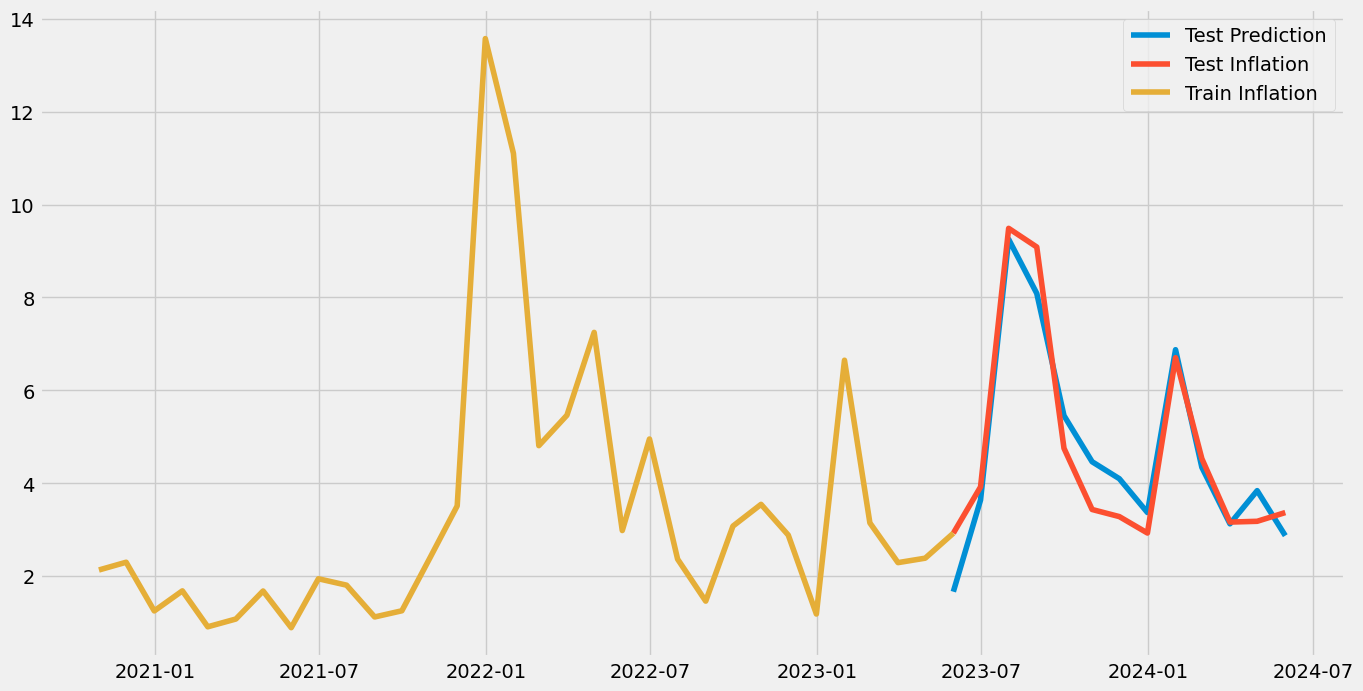

In [145]:
plt.figure(figsize=(15,8))
plt.plot(pd.DataFrame(scaler2.inverse_transform(np.array(model.predict(scaled_data.iloc[-14:-1,:-1])).reshape(-1,1))).set_index(data1.index[-14:-1]),label="Test Prediction")
plt.plot(data["TÜFE"].iloc[-14:-1],label="Test Inflation")
plt.plot(data["TÜFE"].iloc[-45:-13],label="Train Inflation")

plt.legend()

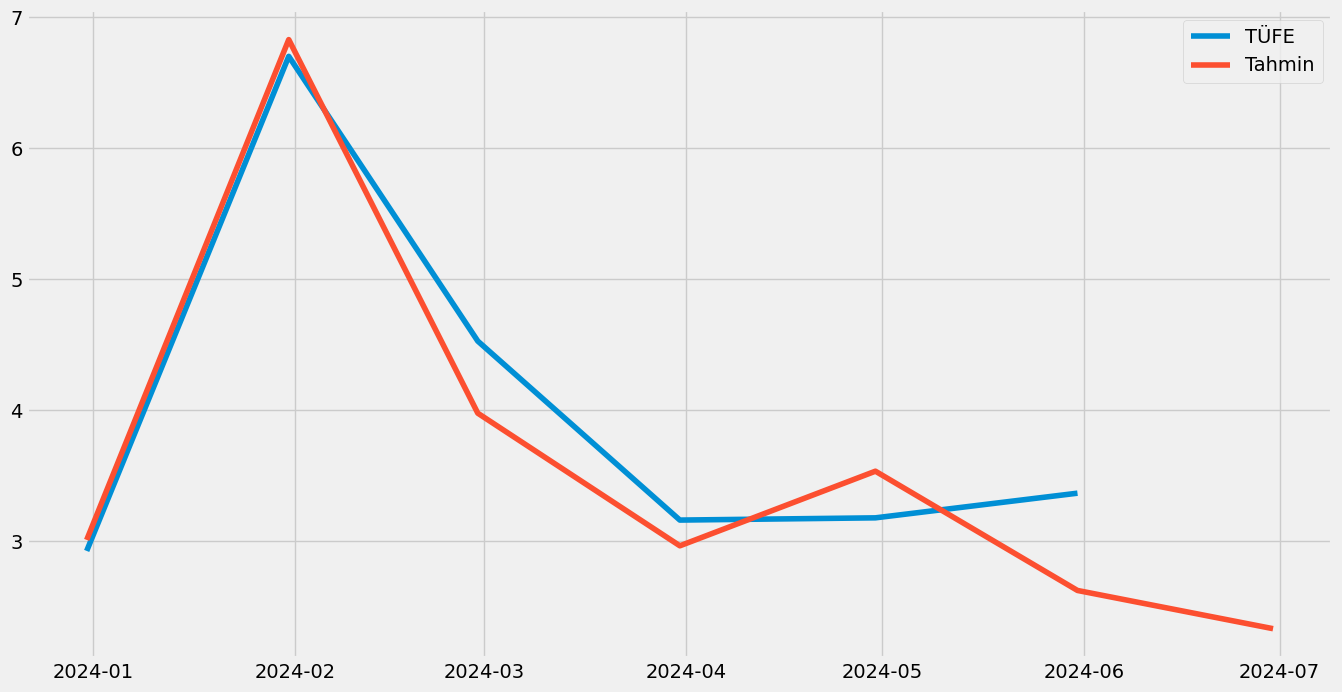

In [146]:
plt.figure(figsize=(15,8))
plt.plot(tahminler["TÜFE"].iloc[:-1],label="TÜFE")
plt.plot(tahminler["NN1"],label="Tahmin")
plt.legend()

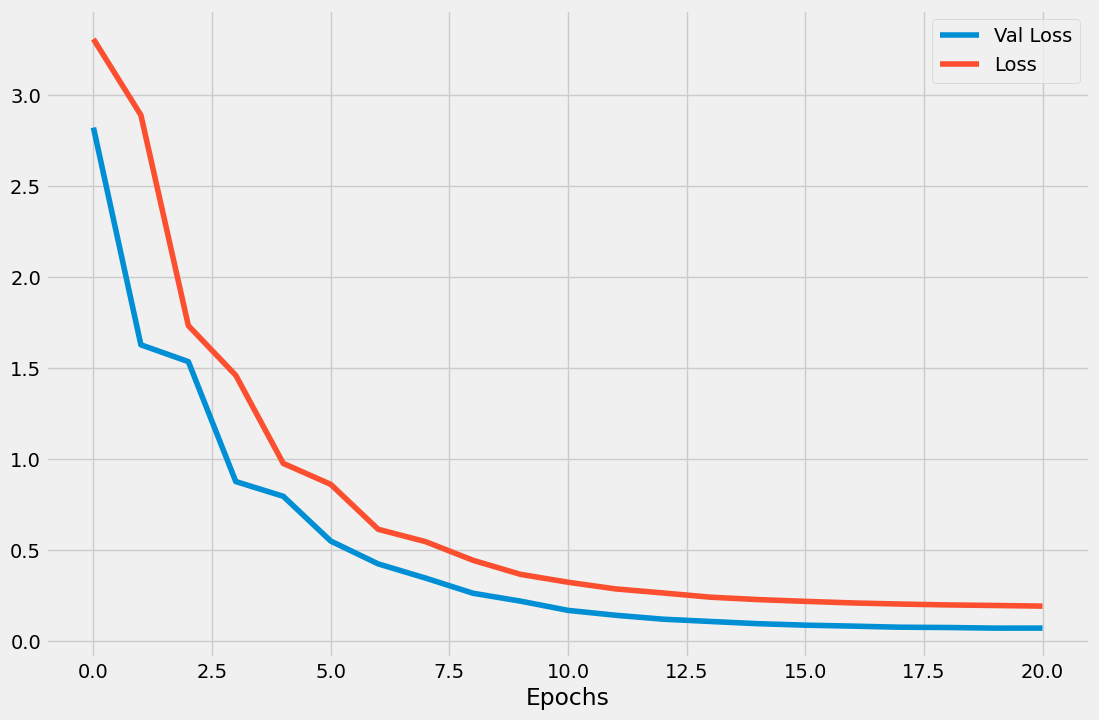

In [147]:
plt.figure(figsize=(12,8))
plt.plot(history.history["val_loss"],label="Val Loss")
plt.plot(history.history["loss"],label="Loss")
plt.xlabel("Epochs")
plt.legend()

In [148]:
kısatahminler=pd.concat([tahminler.iloc[-7:],tahminler2.iloc[-7:,1],tahminler3.iloc[-7:,1],tahminler4.iloc[-7:,1]],axis=1)
kısatahminler["Ortalama"]=kısatahminler.iloc[:,1:].mean(axis=1)
kısatahminler

,TÜFE,NN1,NN2,NN3,NN4,Ortalama
2023-12-31,2.927207,3.011147,3.338740,3.141940,3.368325,3.215038
2024-01-31,6.703310,6.831173,6.835962,4.898625,6.875293,6.360264
2024-02-29,4.529188,3.978722,4.258926,3.815700,4.342071,4.098855
2024-03-31,3.162671,2.966242,2.841101,2.839566,3.125211,2.943030
2024-04-30,3.179759,3.535907,3.996454,3.685323,3.839719,3.764351
2024-05-31,3.368063,2.625299,2.924061,2.778171,2.869797,2.799332
2024-06-30,1.640774,2.333482,2.210308,2.211577,2.236421,2.247947


## Orta Vadeli Tahminler

In [23]:
model=auto_arima(pfaiz["Faiz"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Faiz"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Faiz"]
row=pd.DataFrame({"Faiz":pfaiz.iloc[-4:,0]},index=pd.date_range(start="2024-04-30",periods=4,freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)

faiztahmin.iloc[4:,0]=[50,50,50,50,50,50,50,50,50,50,50,45,40,35,35,35,35,30,30,30,30,30,25,25,25]
faiztahmin

,Faiz
2024-04-30,51.357222
2024-05-31,50.544545
2024-06-30,50.106471
2024-07-31,50.000000
2024-08-31,50.000000
2024-09-30,50.000000
2024-10-31,50.000000
2024-11-30,50.000000
2024-12-31,50.000000
2025-01-31,50.000000


In [24]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [25]:
exog=pd.DataFrame()
exog["X"]=usd["USD/TL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.897922
2007-08-31,94.606608
2007-10-31,98.111410
2007-11-30,110.422510
2007-12-31,107.237150
...,...
2023-11-30,2372.262380
2024-01-31,2403.605577
2024-02-29,2542.824291
2024-04-30,2888.414877


In [26]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,25]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [27]:
faiztahmin.columns=["Faiz"]


In [28]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Faiz"].iloc[95:-13]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Faiz"].iloc[-14:-3],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [29]:
exog=pfaiz["Faiz"].iloc[36:-2]
exog=np.array(exog).reshape(-1,1)

In [30]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [31]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(27,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2024-06-30,8.390175
2024-07-31,8.382133
2024-08-31,8.356908
2024-09-30,8.353280
2024-10-31,8.351119
2024-11-30,8.345414
2024-12-31,8.344594
2025-01-31,8.344105
2025-02-28,8.342815
2025-03-31,8.342629


In [32]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [33]:
import optuna


In [34]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.50,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=usd.index
    sn["y"]=usd.values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=500,freq="D")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(usd.values,predictions["yhat"][:-500])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')
"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.01, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.50,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=usd.index\n    sn["y"]=usd.values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],sea

In [35]:
"""study.best_params"""

'study.best_params'

In [34]:
sn=pd.DataFrame()
sn["ds"]=usd.index
sn["y"]=usd.values
prophet=Prophet(growth="linear",changepoint_prior_scale=8.828175414699565,changepoint_range=0.950080828826867,seasonality_prior_scale=7.816953755754968,n_changepoints=100,interval_width=0.70,yearly_seasonality=False,weekly_seasonality="auto")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=500,freq="D")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:01:31 - cmdstanpy - INFO - Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()

ds
2024-08-31    1.754690
2024-09-30    1.713310
2024-10-31    1.679211
2024-11-30    1.660053
2024-12-31    1.627641
2025-01-31    1.625539
2025-02-28    1.527951
2025-03-31    1.505702
2025-04-30    1.525103
2025-05-31    1.509187
2025-06-30    1.485614
2025-07-31    1.459314
2025-08-31    1.471420
2025-09-30    1.416183
2025-10-31    1.400377
2025-11-30    1.388293
2025-12-31    0.822739
Freq: ME, Name: yhat, dtype: float64

In [36]:
usdtahmin=(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()
usdtahmin

ds
2024-08-31    1.754690
2024-09-30    1.713310
2024-10-31    1.679211
2024-11-30    1.660053
2024-12-31    1.627641
2025-01-31    1.625539
2025-02-28    1.527951
2025-03-31    1.505702
2025-04-30    1.525103
2025-05-31    1.509187
2025-06-30    1.485614
2025-07-31    1.459314
2025-08-31    1.471420
2025-09-30    1.416183
2025-10-31    1.400377
2025-11-30    1.388293
2025-12-31    0.822739
Freq: ME, Name: yhat, dtype: float64

In [37]:
usd_aylık=usd.resample('M').mean().dropna()

In [38]:
usdtahmin1 = []
result = usd_aylık.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([usd_aylık["USD/TL"].loc["2024-03-31":],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2024-03-31", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2024-03-31,31.986743
2024-04-30,32.329467
2024-05-31,32.247882
2024-06-30,32.521235
2024-07-31,32.862117
2024-08-31,33.438745
2024-09-30,34.011654
2024-10-31,34.582782
2024-11-30,35.156875
2024-12-31,35.729102


In [41]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[50:].index\n    sn["y"]=df14[50:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = optuna.create_study(direction=

In [42]:
"""study.best_params"""

'study.best_params'

In [39]:
sn=pd.DataFrame()
sn["ds"]=df14.index
sn["y"]=df14.values
prophet=Prophet(growth="linear",changepoint_prior_scale=9.333547662504625,changepoint_range=0.9362159367416,seasonality_prior_scale=2.378940289163559,n_changepoints=98)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:01:46 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing


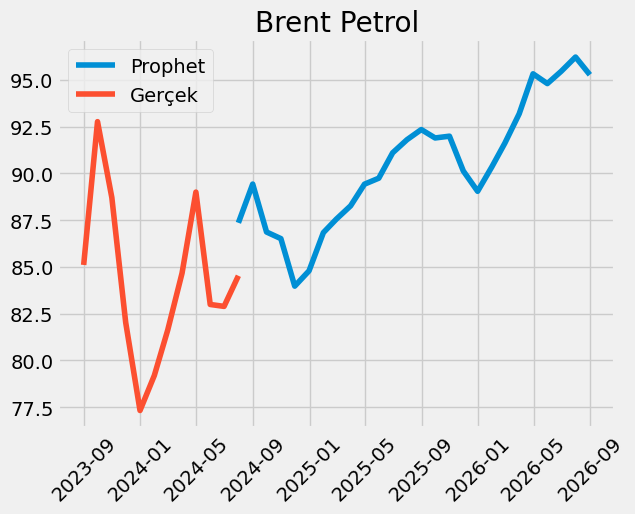

In [40]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-26:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [41]:
brenttahmin=predictions["yhat"][-29:]
brenttahmin

ds
2024-04-30    83.526765
2024-05-31    84.660190
2024-06-30    86.717096
2024-07-31    87.356322
2024-08-31    89.427998
2024-09-30    86.865204
2024-10-31    86.511836
2024-11-30    83.971414
2024-12-31    84.790660
2025-01-31    86.832438
2025-02-28    87.552189
2025-03-31    88.265864
2025-04-30    89.422700
2025-05-31    89.743196
2025-06-30    91.099653
2025-07-31    91.799247
2025-08-31    92.342913
2025-09-30    91.893295
2025-10-31    91.988660
2025-11-30    90.128473
2025-12-31    89.041590
2026-01-31    90.357075
2026-02-28    91.618397
2026-03-31    93.184662
2026-04-30    95.322189
2026-05-31    94.800258
2026-06-30    95.457670
2026-07-31    96.219500
2026-08-31    95.271423
Name: yhat, dtype: float64

In [46]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = o

21:01:52 - cmdstanpy - INFO - Chain [1] start processing
21:01:52 - cmdstanpy - INFO - Chain [1] done processing


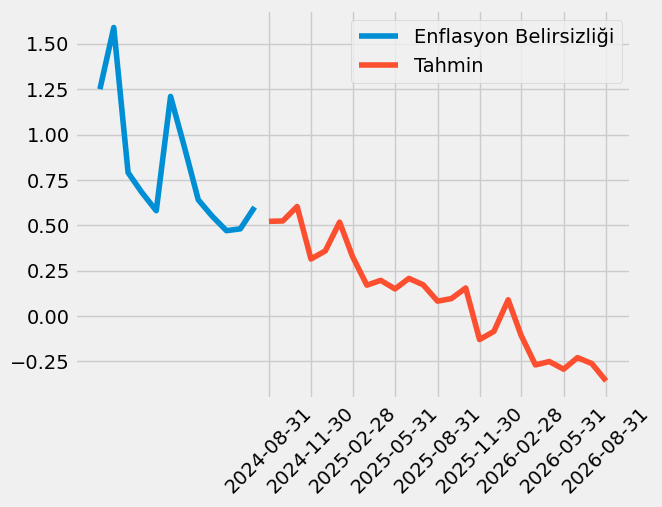

In [42]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=1.7,changepoint_range=0.91,seasonality_prior_scale=0.1053403857042852,n_changepoints=44,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()

In [43]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-26:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0,0]=enf_belirsizlik.iloc[-1,0]
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2024-07-31,0.600000
2024-08-31,0.521407
2024-09-30,0.523522
2024-10-31,0.603051
2024-11-30,0.313802
2024-12-31,0.358463
2025-01-31,0.517260
2025-02-28,0.326938
2025-03-31,0.169687


In [49]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [50]:
#study.best_params

In [44]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

ds
2024-05-31    1.356960
2024-06-30    2.429602
2024-07-31    0.737139
2024-08-31    2.371524
2024-09-30   -2.865762
2024-10-31   -0.406800
2024-11-30   -2.936502
2024-12-31    0.975625
2025-01-31    2.408023
2025-02-28    0.828896
2025-03-31    0.815142
2025-04-30    1.310627
2025-05-31    0.358406
2025-06-30    1.511487
2025-07-31    0.767944
2025-08-31    0.592233
2025-09-30   -0.486900
2025-10-31    0.103778
2025-11-30   -2.022192
2025-12-31   -1.205926
2026-01-31    1.477382
2026-02-28    1.395931
2026-03-31    1.709552
2026-04-30    2.293862
2026-05-31   -0.547545
2026-06-30    0.693471
2026-07-31    0.798081
2026-08-31   -0.985328
Name: yhat, dtype: float64

In [45]:
(usdtahmin1[:-5].pct_change(periods=1)*100).dropna()

,USD/TL
2024-04-30,1.071456
2024-05-31,-0.252354
2024-06-30,0.847663
2024-07-31,1.048181
2024-08-31,1.754690
2024-09-30,1.713310
2024-10-31,1.679211
2024-11-30,1.660053
2024-12-31,1.627641
2025-01-31,1.625539


In [53]:
(brenttahmin1[:-7]).dropna()

ds
2024-05-31    1.003012
2024-06-30    2.348736
2024-07-31    1.178192
2024-08-31    2.824667
2024-09-30   -2.624859
2024-10-31    0.313325
2024-11-30   -2.491957
2024-12-31    0.860392
2025-01-31    1.536794
2025-02-28    0.774586
2025-03-31    0.971680
2025-04-30    1.369275
2025-05-31    0.258661
2025-06-30    1.592406
2025-07-31    1.204928
2025-08-31    1.090437
2025-09-30   -0.221929
2025-10-31    0.492880
2025-11-30   -1.804315
2025-12-31   -1.264276
2026-01-31    1.095298
Name: yhat, dtype: float64

In [46]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1[:-7]).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2024-04-28",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2024-04-30,0.290660
2024-05-31,2.171117
2024-06-30,1.591051
2024-07-31,3.444562
2024-08-31,-1.161357
2024-09-30,1.299540
2024-10-31,-1.306601
2024-11-30,2.651874
2024-12-31,4.074857
2025-01-31,2.467909


In [55]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_rang

In [47]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
prophet=Prophet(changepoint_prior_scale=0.904897796889,changepoint_range=0.9529543315216538,growth='linear',seasonality_prior_scale=3.03031163229546,n_changepoints=15)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:02:00 - cmdstanpy - INFO - Chain [1] start processing
21:02:00 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
paraarzitahmin=(predictions["yhat"]).tail(25)
paraarzitahmin

ds
2024-08-31    1.815775
2024-09-30    3.214034
2024-10-31    3.060561
2024-11-30    2.708167
2024-12-31    2.724440
2025-01-31    1.252807
2025-02-28    1.601338
2025-03-31    3.280690
2025-04-30    2.800332
2025-05-31    2.373849
2025-06-30    2.762143
2025-07-31    1.885679
2025-08-31    1.950098
2025-09-30    2.096894
2025-10-31    1.805333
2025-11-30    1.752260
2025-12-31    2.423969
2026-01-31    0.532652
2026-02-28    1.116621
2026-03-31    2.499418
2026-04-30    1.443816
2026-05-31    1.655291
2026-06-30    2.273358
2026-07-31    0.955593
2026-08-31    2.078546
Name: yhat, dtype: float64

In [49]:
paraarzitahmin1 = paraarzitahmin
paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-08-30", periods=len(paraarzitahmin), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-6:,0]},index=pd.date_range(start="2024-02-28",periods=6,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
np.cumprod(1+(paraarzitahmin1.loc["2024-01-31":"2024-12-31"])/100)

,Para Arzi
2024-02-29,1.014672
2024-03-31,1.038990
2024-04-30,1.059585
2024-05-31,1.079288
2024-06-30,1.112821
2024-07-31,1.135684
2024-08-31,1.156305
2024-09-30,1.193469
2024-10-31,1.229996
2024-11-30,1.263306


In [59]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [60]:
#study.best_params

In [61]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,5),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3.values,predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,5),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=

In [62]:
"""study.best_params"""

'study.best_params'

In [50]:
sn=pd.DataFrame()
sn["ds"]=kredi["Kredi"].index
sn["y"]=kredi["Kredi"].values
prophet=Prophet(changepoint_prior_scale=0.01099759561372614,changepoint_range=0.0589785485153,growth="linear",seasonality_prior_scale=0.04157847860739,n_changepoints=10,yearly_seasonality=True,weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:02:04 - cmdstanpy - INFO - Chain [1] start processing
21:02:04 - cmdstanpy - INFO - Chain [1] done processing


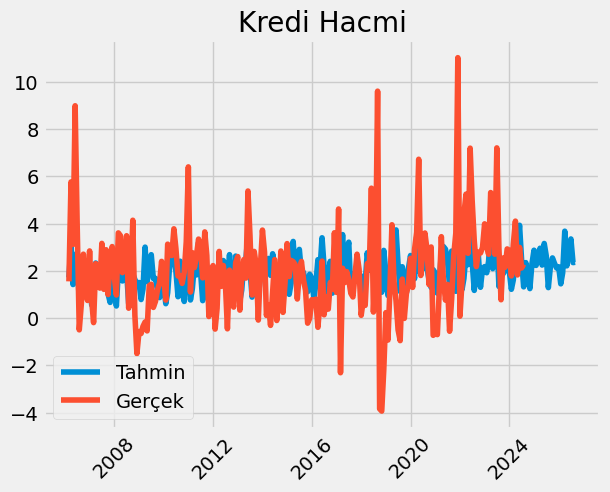

In [64]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(kredi["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [51]:
kreditahmin=(predictions["yhat"]).tail(25)
kreditahmin

ds
2024-08-31    2.288350
2024-09-30    1.776937
2024-10-31    1.200400
2024-11-30    2.233995
2024-12-31    2.806806
2025-01-31    2.172315
2025-02-28    2.609158
2025-03-31    2.902175
2025-04-30    2.167733
2025-05-31    3.095529
2025-06-30    2.581646
2025-07-31    1.216825
2025-08-31    2.131384
2025-09-30    2.477770
2025-10-31    2.242467
2025-11-30    2.071324
2025-12-31    2.111219
2026-01-31    1.393058
2026-02-28    1.843709
2026-03-31    3.605318
2026-04-30    2.133195
2026-05-31    2.930997
2026-06-30    3.275778
2026-07-31    2.255035
2026-08-31    2.292120
Name: yhat, dtype: float64

In [52]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-08-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":kredi.iloc[-4:,0]},index=pd.date_range(start="2024-04-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2024-04-30,1.832087
2024-05-31,2.996833
2024-06-30,2.311270
2024-07-31,2.124771
2024-08-31,2.288350
2024-09-30,1.776937
2024-10-31,1.200400
2024-11-30,2.233995
2024-12-31,2.806806
2025-01-31,2.172315


In [67]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,150),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3"].index
    sn["y"]=m3["M3"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,150),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3"].index\n    sn["y"]=m3["M3"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["

In [53]:
sn=pd.DataFrame()
sn["ds"]=m3["M3"].index
sn["y"]=m3["M3"].values
prophet=Prophet(changepoint_prior_scale=2.5,changepoint_range=0.9,growth='linear',seasonality_prior_scale=4.7636997959024185,n_changepoints=10)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=18,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:02:09 - cmdstanpy - INFO - Chain [1] start processing
21:02:09 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
m3tahmin=(predictions["yhat"].tail(18))


m3tahmin1 = np.array(m3tahmin).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-08-30", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2024-04-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2024-04-30,2.405048
2024-05-31,3.570039
2024-06-30,2.937146
2024-07-31,2.491858
2024-08-31,1.824709
2024-09-30,3.024781
2024-10-31,3.193490
2024-11-30,2.765825
2024-12-31,1.996019
2025-01-31,0.983111


In [70]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [71]:
#study.best_params

In [72]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"],predictions["yhat"][:-36])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scal

In [55]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean()],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf["M3"]=m3tahmin1.shift(1)
tahmindf["Para Arzi"]=paraarzitahmin1.shift(1)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].rolling(3).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["Politika Faizi"]=faiztahmin["Faiz"]




tahmindf=tahmindf[['USD/TL', 'Motorin', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'M3', 'Kredi','İşsizlik','Politika Faizi']]

tahmindf.columns=["USD/TL","Motorin","Zam","Enflasyon Belirsizliği",'ParaArzi','M3', 'Kredi','İşsizlik','Politika Faizi']



tahmindf=tahmindf.loc["2024-07-30":]
tahmindf["Motorin"].iloc[0]=8.88
tahmindf["Kredi"].iloc[0]=2.02
tahmindf

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,M3,Kredi,İşsizlik,Politika Faizi
2024-07-31,0.548566,8.880000,0.0,0.600000,3.106922,2.937146,2.020000,8.382133,50.0
2024-08-31,1.219756,-1.161357,0.0,0.521407,2.054508,2.491858,2.241463,8.356908,50.0
2024-09-30,1.508184,1.299540,0.0,0.523522,1.815775,1.824709,2.063353,8.353280,50.0
2024-10-31,1.715305,-1.306601,0.0,0.603051,3.214034,3.024781,1.755229,8.351119,50.0
2024-11-30,1.683893,2.651874,0.0,0.313802,3.060561,3.193490,1.737111,8.345414,50.0
2024-12-31,1.655350,4.074857,0.0,0.358463,2.708167,2.765825,2.080400,8.344594,50.0
2025-01-31,1.637557,2.467909,30.0,0.517260,2.724440,1.996019,2.404372,8.344105,50.0
2025-02-28,1.593173,2.355548,0.0,0.326938,1.252807,0.983111,2.529426,8.342815,50.0
2025-03-31,1.552436,2.836063,0.0,0.169687,1.601338,1.511227,2.561216,8.342629,50.0
2025-04-30,1.519571,1.888975,0.0,0.196061,3.280690,2.927854,2.559689,8.342519,50.0


In [56]:
data["TÜFE Lag"]=(enf.pct_change()*100).shift(1).dropna()["TÜFE"]
tahmindf["TÜFE Lag"]=0
tahmindf["TÜFE Lag"].iloc[0]=data["TÜFE"].iloc[-1]

In [57]:
data.loc["2023-06-30","TÜFE Lag"]=data.loc["2023-05-31","TÜFE"]

In [58]:
data=data.dropna()

In [59]:
data1=data[['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1',
       'ParaArzi', 'Kredi', 'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2',
       'ÜFEt1', 'TÜFECt1','Zam', 'TÜFE']]

In [ ]:
import pandas as pd
from prophet import Prophet
import optuna
from sklearn.metrics import mean_squared_error
import cmdstanpy
import warnings
warnings.filterwarnings("ignore")


data1 = data.rename(columns={'TÜFE': 'y'})
data1["ds"]=pd.to_datetime(data.index)
data1=data1.reset_index().drop("index",axis=1)
data1["Motorin"].iloc[-1]=-1.61




regressors = ['USD/TL', 'Motorin','M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İşsizlik', 'Zam','ÜFEt1']

# Prepare the data for Prophet
prophet_data = data1[['ds', 'y'] + regressors]

# Split the data into training and test sets
train_size = int(len(prophet_data) * 0.9)
train_data = prophet_data[:train_size]
test_data = prophet_data[train_size:]



def objective(trial):
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.99)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.001, 10.0)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.001, 10.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    n_changepoints = trial.suggest_int('n_changepoints', 1, 100)
    yearly_seasonality = trial.suggest_categorical('yearly_seasonality', [True, False, "auto"])
    weekly_seasonality = trial.suggest_categorical('weekly_seasonality', [True, False, "auto"])
    daily_seasonality = trial.suggest_categorical('daily_seasonality', [True, False, "auto"])

    # Initialize the Prophet model
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode,
        n_changepoints=n_changepoints,
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=daily_seasonality
    )

    
    # Add selected regressors to the model
    for regressor in regressors:
        model.add_regressor(regressor)


    
    # Fit the model
    model.fit(train_data)
    
    # Make a DataFrame to hold future dates and include the regressors
    future = test_data[['ds'] + list(regressors)].copy()
    
    # Make predictions
    forecast = model.predict(future)
    
    # Merge actual and predicted values
    results = test_data[['ds', 'y']].copy()
    results = results.merge(forecast[['ds', 'yhat']], on='ds')
    
    # Calculate MSE
    mse = mean_squared_error(results['y'], results['yhat'])
    
    return mse

# Create a study object and optimize the objective function
warnings.filterwarnings("ignore")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)  # Adjust n_trials as needed

# Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params


model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    n_changepoints=best_params['n_changepoints'],
    yearly_seasonality=best_params['yearly_seasonality'],
    weekly_seasonality=best_params['weekly_seasonality'],
    daily_seasonality=best_params['daily_seasonality'],
    interval_width=0.7
)

for regressor in regressors:
    model.add_regressor(regressor)

model.fit(train_data)

# Make predictions on the test data
future = test_data[['ds'] + list(regressors)].copy()
forecast = model.predict(future)

# Merge actual and predicted values
results = test_data[['ds', 'y']].copy()
results = results.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

# Calculate and print performance metrics
mse = mean_squared_error(results['y'], results['yhat'])
print(f'Mean Squared Error: {mse:.4f}')



In [60]:
data1["ds"]=pd.to_datetime(data1.index)
data1=data1.reset_index()

In [61]:
del data1["index"]

In [ ]:
üfe=pd.DataFrame()
üfe["ds"]=pd.to_datetime(data1["ds"])
üfe["y"]=data1["ÜFEt1"].values
üfe["USD/TL"]=data1["USD/TL"].values
train_size = int(len(üfe) * 0.9)
train_data = üfe[:train_size]
test_data = üfe[train_size:]



def objective(trial):
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.01, 0.99)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10.0)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 10.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    n_changepoints = trial.suggest_int('n_changepoints', 1, 50)
    yearly_seasonality = trial.suggest_categorical('yearly_seasonality', [True, False, "auto"])
    weekly_seasonality = trial.suggest_categorical('weekly_seasonality', [True, False, "auto"])
    daily_seasonality = trial.suggest_categorical('daily_seasonality', [True, False, "auto"])

    # Initialize the Prophet model
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode,
        n_changepoints=n_changepoints,
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=daily_seasonality
    )

    

    model.add_regressor("USD/TL")
    model.fit(train_data)
    

    future = test_data[['ds' , 'USD/TL']].copy()
    
    # Make predictions
    forecast = model.predict(future)
    
    # Merge actual and predicted values
    results = test_data[['ds', 'y']].copy()
    results = results.merge(forecast[['ds', 'yhat']], on='ds')
    
    # Calculate MSE
    mse = mean_squared_error(results['y'], results['yhat'])
    
    return mse

# Create a study object and optimize the objective function
warnings.filterwarnings("ignore")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)  # Adjust n_trials as needed

In [62]:
üfe=pd.DataFrame()
üfe["ds"]=pd.to_datetime(data1["ds"])
üfe["y"]=data1["ÜFEt1"].values
üfe["USD/TL"]=data1["USD/TL"].values
train_size = int(len(üfe) * 0.9)
train_data = üfe[:train_size]
test_data = üfe[train_size:]


best_params = {'changepoint_prior_scale': 0.9878008112944574,
 'seasonality_prior_scale': 8.034556602260999,
 'holidays_prior_scale': 0.010037440010290376,
 'seasonality_mode': 'additive',
 'n_changepoints': 7,
 'yearly_seasonality': False,
 'weekly_seasonality': True,
 'daily_seasonality': 'auto'}


model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    n_changepoints=best_params['n_changepoints'],
    yearly_seasonality=best_params['yearly_seasonality'],
    weekly_seasonality=best_params['weekly_seasonality'],
    daily_seasonality=best_params['daily_seasonality'],
    interval_width=0.5
)

model.add_regressor("USD/TL")

model.fit(train_data)

future = test_data[['ds' , 'USD/TL']].copy()
forecast = model.predict(future)

21:02:30 - cmdstanpy - INFO - Chain [1] start processing
21:02:30 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
tahmindf["ds"]=pd.to_datetime(tahmindf.index)
tahmindf=tahmindf.reset_index().drop("index",axis=1)


In [64]:
future=tahmindf[["ds","USD/TL"]]
forecast = model.predict(future)

In [65]:
üfetahmin=forecast[["ds","yhat_lower"]]
üfetahmin

,ds,yhat_lower
0,2024-07-31,1.739570
1,2024-08-31,1.692923
2,2024-09-30,2.123278
3,2024-10-31,1.797114
4,2024-11-30,1.664081
5,2024-12-31,1.416726
6,2025-01-31,1.347733
7,2025-02-28,1.268843
8,2025-03-31,1.852668
9,2025-04-30,1.535741


In [66]:
tahmindf["ÜFEt1"]=üfetahmin["yhat_lower"].values
tahmindf["TÜFEt-1"]=0
tahmindf["TÜFEt-1"].iloc[0]=data["TÜFE"].iloc[-1]
tahmindf["ÜFEt1"].iloc[0]=1.38

In [67]:
data2 = data.rename(columns={'TÜFE': 'y'})
data2["ds"]=data.index
data2=data2.reset_index().drop("index",axis=1)
data2["Motorin"].iloc[-1]=-1.61
# Define the list of additional regressors
regressors = ['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1',
       'ParaArzi', 'Kredi', 'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2',
       'ÜFEt1', 'TÜFECt1','Zam']

# Prepare the data for Prophet
prophet_data = data2[['ds', 'y'] + regressors]

# Split the data into training and test sets
train_size = int(len(prophet_data) * 0.9)
train_data = prophet_data[:train_size]
test_data = prophet_data[train_size:]


In [96]:
params=  {'changepoint_prior_scale': 0.015216161126164657, 'seasonality_prior_scale': 0.0029079778527052727, 'holidays_prior_scale': 2.111013606893588, 'seasonality_mode': 'multiplicative', 'n_changepoints': 92, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
best_regressor_combination = ('USD/TL', 'Motorin', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İşsizlik', 'Zam','ÜFEt1')

model = Prophet(**params,interval_width=0.4)

for regressor in best_regressor_combination:
    model.add_regressor(regressor)

model.fit(train_data)

# Make predictions on the test data
future = test_data[['ds'] + list(best_regressor_combination)].copy()
forecast1 = model.predict(future)

results1 = data2[['ds', 'y']].iloc[-13:].copy()
results1 = results1.merge(forecast1[['ds', 'yhat']], on='ds')
results1.iloc[-2,-1]+=0.66
results1=results1.set_index(pd.to_datetime(results1["ds"]))
del results1["ds"]
forecast1=forecast1.set_index(pd.to_datetime(forecast1["ds"]))

future=tahmindf[['ds'] + list(best_regressor_combination)]
forecast1= model.predict(future)


22:55:04 - cmdstanpy - INFO - Chain [1] start processing
22:55:05 - cmdstanpy - INFO - Chain [1] done processing


In [97]:
params=  {'changepoint_prior_scale': 0.009773311452850347, 'seasonality_prior_scale': 0.009822947368276132, 'holidays_prior_scale': 2.734013344954643, 'seasonality_mode': 'multiplicative', 'n_changepoints': 63, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'daily_seasonality': True}
best_regressor_combination = ('USD/TL', 'Motorin', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İşsizlik', 'Zam','ÜFEt1','ParaArzi')

model = Prophet(**params,interval_width=0.4)

for regressor in best_regressor_combination:
    model.add_regressor(regressor)

model.fit(train_data)

# Make predictions on the test data
future = test_data[['ds'] + list(best_regressor_combination)].copy()
forecast2 = model.predict(future)

results2 = data2[['ds', 'y']].iloc[-13:].copy()
results2 = results2.merge(forecast2[['ds', 'yhat']], on='ds')
results2.iloc[-2,-1]+=0.66
results2=results2.set_index(pd.to_datetime(results2["ds"]))
del results2["ds"]
forecast2=forecast2.set_index(pd.to_datetime(forecast2["ds"]))

future=tahmindf[['ds'] + list(best_regressor_combination)]
forecast2= model.predict(future)

22:55:06 - cmdstanpy - INFO - Chain [1] start processing
22:55:06 - cmdstanpy - INFO - Chain [1] done processing


In [98]:
params= {'changepoint_prior_scale': 0.017308864356226254, 'seasonality_prior_scale': 0.03523965598481892, 'holidays_prior_scale': 0.141087251967483, 'seasonality_mode': 'multiplicative', 'n_changepoints': 46, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'daily_seasonality': 'auto'}
best_regressor_combination = ('USD/TL', 'Motorin', 'Enflasyon Belirsizliği', 'Kredi', 'İşsizlik', 'Zam','ÜFEt1')

model = Prophet(**params,interval_width=0.4)

for regressor in best_regressor_combination:
    model.add_regressor(regressor)

model.fit(train_data)

# Make predictions on the test data
future = test_data[['ds'] + list(best_regressor_combination)].copy()
future = test_data[['ds'] + list(best_regressor_combination)].copy()
forecast3 = model.predict(future)

results3 = data2[['ds', 'y']].iloc[-13:].copy()
results3 = results3.merge(forecast3[['ds', 'yhat']], on='ds')
results3.iloc[-2,-1]+=0.66
results3=results3.set_index(pd.to_datetime(results3["ds"]))
del results3["ds"]
forecast3=forecast3.set_index(pd.to_datetime(forecast3["ds"]))

future=tahmindf[['ds'] + list(best_regressor_combination)]
forecast3= model.predict(future)

22:55:07 - cmdstanpy - INFO - Chain [1] start processing
22:55:07 - cmdstanpy - INFO - Chain [1] done processing


In [99]:
params= {'changepoint_prior_scale': 0.022684389480075222, 'seasonality_prior_scale': 0.004633178781555632, 'holidays_prior_scale': 0.09701041865099715, 'seasonality_mode': 'multiplicative', 'n_changepoints': 56, 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True}
best_regressor_combination = ('USD/TL', 'Motorin', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İşsizlik', 'Zam')

model = Prophet(**params,interval_width=0.4)

for regressor in best_regressor_combination:
    model.add_regressor(regressor)

model.fit(train_data)

# Make predictions on the test data
future = test_data[['ds'] + list(best_regressor_combination)].copy()
future = test_data[['ds'] + list(best_regressor_combination)].copy()
forecast4 = model.predict(future)

results4 = data2[['ds', 'y']].iloc[-13:].copy()
results4 = results4.merge(forecast4[['ds', 'yhat']], on='ds')
results4.iloc[-2,-1]+=0.66
results4=results4.set_index(pd.to_datetime(results4["ds"]))
del results4["ds"]
forecast4=forecast4.set_index(pd.to_datetime(forecast4["ds"]))

future=tahmindf[['ds'] + list(best_regressor_combination)]
forecast4= model.predict(future)

22:55:08 - cmdstanpy - INFO - Chain [1] start processing
22:55:08 - cmdstanpy - INFO - Chain [1] done processing


In [100]:
params={'changepoint_prior_scale': 0.01806485402864186, 'seasonality_prior_scale': 0.0014006120341357132, 'holidays_prior_scale': 0.3157449729829788, 'seasonality_mode': 'multiplicative', 'n_changepoints': 19, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': True}
best_regressor_combination = ('USD/TL', 'Motorin', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İşsizlik', 'Zam','ÜFEt1')

model = Prophet(**params,interval_width=0.4)

for regressor in best_regressor_combination:
    model.add_regressor(regressor)

model.fit(train_data)

# Make predictions on the test data
future = test_data[['ds'] + list(best_regressor_combination)].copy()
future = test_data[['ds'] + list(best_regressor_combination)].copy()
forecast5 = model.predict(future)

results5 = data2[['ds', 'y']].iloc[-13:].copy()
results5 = results5.merge(forecast5[['ds', 'yhat']], on='ds')
results5.iloc[-2,-1]+=0.66
results5=results5.set_index(pd.to_datetime(results5["ds"]))
del results5["ds"]
forecast5=forecast5.set_index(pd.to_datetime(forecast5["ds"]))

future=tahmindf[['ds'] + list(best_regressor_combination)]
forecast5= model.predict(future)


22:55:10 - cmdstanpy - INFO - Chain [1] start processing
22:55:10 - cmdstanpy - INFO - Chain [1] done processing


In [101]:
futures=pd.concat([forecast1[["yhat","yhat_lower"]],forecast2[["yhat","yhat_lower"]],forecast3[["yhat","yhat_lower"]],forecast4[["yhat","yhat_lower"]],forecast5[["yhat","yhat_lower"]]],axis=1)
futures=futures.set_index(pd.to_datetime(tahmindf["ds"]))
futures.columns=["p1","p1min","p2","p2min","p3","p3min","p4","p4min","p5","p5min"]
temmuz=futures[["p1","p2","p3","p4","p5"]].mean(axis=1).iloc[0]
futures["ortalama"]=futures[["p1min","p2min","p3min","p4min","p5min"]].mean(axis=1)
futures["ortalama"].iloc[0]=temmuz
std=futures[["p1min","p2min","p3min","p4min","p5min"]].std(axis=1)
futures["max"]=futures[["p1","p2","p3","p4","p5"]].min(axis=1)+std
futures["min"]=futures[["p1min","p2min","p3min","p4min","p5min"]].min(axis=1)-std
futures["min"].iloc[0]=futures[["p1","p2","p3","p4","p5"]].min(axis=1).iloc[0]
futures

,p1,p1min,p2,p2min,p3,p3min,p4,p4min,p5,p5min,ortalama,max,min
ds,,,,,,,,,,,,,
2024-07-31,3.106520,2.673198,3.192098,2.702197,3.193727,2.764264,3.467539,2.886489,3.110237,2.510279,3.214024,3.243779,3.106520
2024-08-31,2.288456,1.815897,2.254739,1.810849,2.531293,2.033832,2.409837,1.854461,2.234703,1.609742,1.824956,2.385615,1.458830
2024-09-30,2.551022,2.059410,2.466943,1.963960,3.134476,2.632207,2.677089,2.089768,2.527682,1.930820,2.135233,2.752389,1.645374
2024-10-31,2.395976,1.931610,2.543152,2.083223,3.037600,2.484173,2.534814,2.003643,2.349134,1.831161,2.066762,2.600262,1.580033
2024-11-30,2.368652,1.847271,2.498520,2.103291,2.639287,2.156190,2.538973,1.932900,2.342637,1.777381,1.963407,2.505238,1.614780
2024-12-31,2.557163,2.054456,2.614878,2.136510,3.339608,2.823273,2.806673,2.262221,2.550901,1.978361,2.250964,2.887684,1.641578
2025-01-31,3.942412,3.402743,3.995873,3.528530,4.775549,4.300696,4.430613,3.818909,4.142942,3.575485,3.725273,4.297746,3.047409
2025-02-28,2.462850,2.001736,2.291924,1.842924,2.746474,2.299882,2.697350,2.093728,2.446996,1.874618,2.022578,2.476696,1.658152
2025-03-31,2.419461,1.916768,2.303616,1.797020,2.888793,2.452144,2.558182,1.958325,2.401168,1.791525,1.983156,2.575802,1.519339


In [102]:
def create_tüfe(data):
    tüfetahmin = []
    result = enf["TÜFE"].iloc[-1]
    pred=np.array(data.values).reshape(1,-1).ravel()
    for i in range(len(pred)):
        result *= (1 + (pred[i] / 100))
        tüfetahmin.append(result)
    tüfetahmin[0]=enf["TÜFE"].iloc[-1]*(1+(data[0]/100))

    tüfetahmin = np.array(tüfetahmin).reshape(-1, 1)
    tüfetahmin = pd.DataFrame(tüfetahmin)
    tüfetahmin = tüfetahmin.set_index(pd.date_range(start="2024-07-30", periods=len(tüfetahmin), freq="1M"))
    return tüfetahmin


In [103]:
tüfetahmin1=create_tüfe(futures["ortalama"])
tüfetahmin1.columns=["Ortalama"]
tüfetahmin2=create_tüfe(futures["max"])
tüfetahmin2.columns=["Max"]
tüfetahmin3=create_tüfe(futures["min"])
tüfetahmin3.columns=["Min"]
tüfetahmin4=create_tüfe(futures["p1min"])
tüfetahmin4.columns=["p1"]
tüfetahmin5=create_tüfe(futures["p2min"])
tüfetahmin5.columns=["p2"]
tüfetahmin6=create_tüfe(futures["p3min"])
tüfetahmin6.columns=["p3"]
tüfetahmin7=create_tüfe(futures["p4min"])
tüfetahmin7.columns=["p4"]
tüfetahmin8=create_tüfe(futures["p5min"])
tüfetahmin8.columns=["p5"]


In [104]:
tüfetahmin=pd.concat([tüfetahmin1,tüfetahmin2,tüfetahmin3,tüfetahmin4,tüfetahmin5,tüfetahmin6,tüfetahmin7,tüfetahmin8],axis=1)

In [105]:
dates=pd.date_range('2006-02-28','2024-03-28' , freq='1M')
df=pd.DataFrame()

df["CPI"]=enf["TÜFE"]
df=df.set_index(pd.to_datetime(enf.index))




dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]



dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








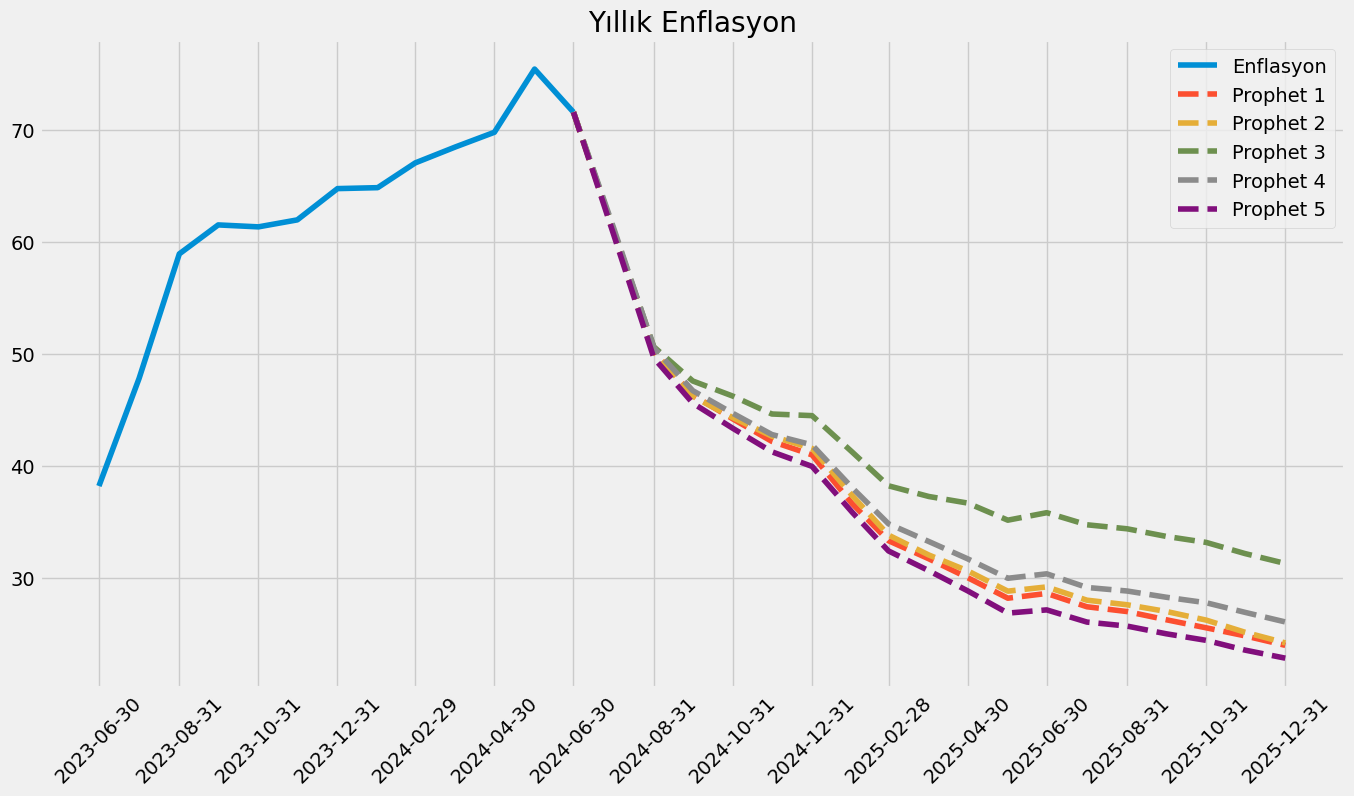

In [106]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.plot(dfas["Ortalama"].loc["2023-06-30":"2024-07-30"],label="Enflasyon")
plt.plot(dfas["p1"].loc["2024-06-30":],'--',label="Prophet 1")
plt.plot(dfas["p2"].loc["2024-06-30":],'--',label="Prophet 2")
plt.plot(dfas["p3"].loc["2024-06-30":],'--',label="Prophet 3")
plt.plot(dfas["p4"].loc["2024-06-30":],'--',label="Prophet 4")
plt.plot(dfas["p5"].loc["2024-06-30":],'--',label="Prophet 5")
plt.legend(loc=0)
plt.xticks(dfas.loc["2023-06-30":].index[::2],rotation=45)
plt.title("Yıllık Enflasyon")
plt.show()

In [107]:
dfas["Min"]=dfas.min(axis=1)

In [108]:
sonu12024=str(dfas["Ortalama"].loc["2024-12-31"])[:5]
min2024=str(dfas["Min"].loc["2024-12-31"])[:5]
max2024=str(dfas["Max"].loc["2024-12-31"])[:5]

In [81]:
params = {
    'series': "TP.PKAUO.S01.D.U",
    'startDate': "01-07-2024",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ay12sonra = formatted_response['items']
ay12sonra = pd.DataFrame(ay12sonra)


ay12sonra = ay12sonra.drop(columns=['UNIXTIME','Tarih'])
ay12sonra.columns = ['Beklenti']
ay12sonra['Beklenti'] = pd.to_numeric(ay12sonra['Beklenti'])
ay12sonra=ay12sonra.set_index(pd.date_range(start="2024-07-01",freq="M",periods=len(ay12sonra)))
ay12sonra=ay12sonra.dropna()
ay12sonra

,Beklenti
2024-07-31,42.95


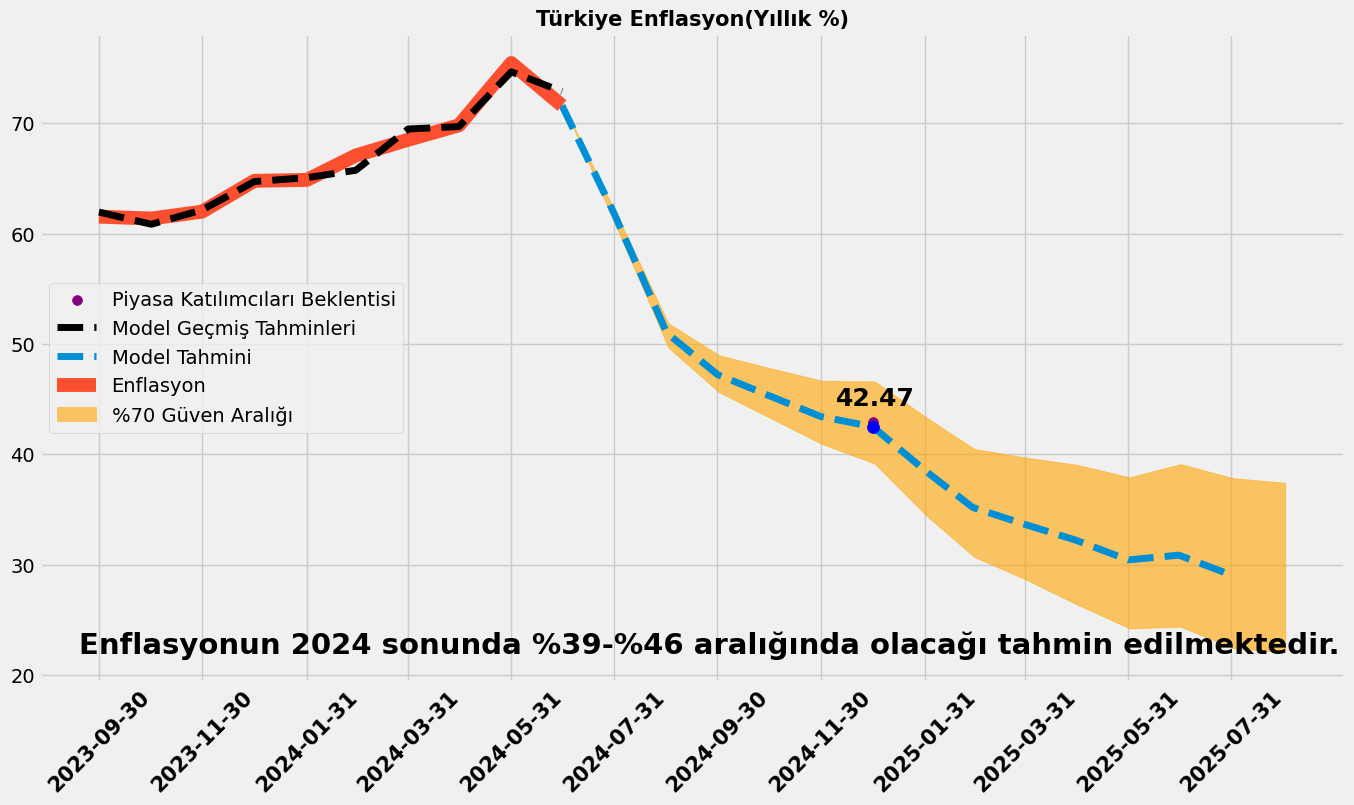

In [109]:
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["Beklenti"].values,color="purple",zorder=3,s=50,label="Piyasa Katılımcıları Beklentisi")
geçmiş=pd.DataFrame({"Tahmin":[61.94,60.84,62.13,64.71,65.06,65.73,69.47,69.69,74.65,72.87]})
geçmiş=geçmiş.set_index(pd.date_range(start="2023-09-30",end="2024-06-30",freq="M"))
plt.plot(geçmiş["Tahmin"],'--',label="Model Geçmiş Tahminleri",color="black",linewidth=5,zorder=3)
plt.scatter(x=dfas.loc["2024-12-31":].index[0],y=dfas["Ortalama"].loc["2024-12-31"],color='blue',zorder=4,s=75)
plt.plot(dfas["Ortalama"].loc["2024-06-30":"2025-08-30"],'--',label="Model Tahmini",linewidth=5)
plt.plot(dfas["Ortalama"].loc["2023-09-30":"2024-06-30"],label="Enflasyon",linewidth=10)
plt.fill_between(dfas.loc["2024-06-30":"2025-09-30"].index.strftime("%Y-%m"), dfas["Max"].loc["2024-06-30":"2025-09-30"].shift(1), dfas["Min"].loc["2024-06-30":"2025-09-30"].shift(1), alpha=0.6, color='orange',label="%70 Güven Aralığı")
annotation_date = mdates.datestr2num('2024-09')
plt.text(mdates.datestr2num('2025-01'), float(sonu12024)+2, sonu12024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 22, f"Enflasyonun 2024 sonunda %{min2024[:2]}-%{max2024[:2]} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='center',fontweight='bold')
plt.xticks(dfas.loc["2023-09-30":"2025-08-30"].index[::2],rotation=45,fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=6)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()

In [110]:
futures.loc["2024-07-31", ["p1min", "p2min", "p3min", "p4min", "p5min"]] = futures.loc["2024-07-31", ["p1", "p2", "p3", "p4", "p5"]].values


In [111]:
modelaylık=futures[[ 'p1min','p2min','p3min','p4min','p5min', 'ortalama']]
modelaylık.columns=["Prophet 1","Prophet 2","Prophet 3","Prophet 4","Prophet 5","Ortalama"]
modelaylık.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [112]:
yıllıktahmin1=dfas[['Ortalama','p1','p2','p3','p4','p5', 'Max',
       'Min']]


yıllıktahmin1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')

In [113]:
yıllıktahmin=pd.read_csv("C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv")
yıllıktahmin=yıllıktahmin.set_index(yıllıktahmin["Unnamed: 0"])
del yıllıktahmin["Unnamed: 0"]
yıllıktahmin=yıllıktahmin.rename_axis(["Tarih"])
yıllıktahmin

,Ortalama,p1,p2,p3,p4,p5,Max,Min
Tarih,,,,,,,,
2007-01-31,9.929595,9.929595,9.929595,9.929595,9.929595,9.929595,9.929595,9.929595
2007-02-28,10.158269,10.158269,10.158269,10.158269,10.158269,10.158269,10.158269,10.158269
2007-03-31,10.863263,10.863263,10.863263,10.863263,10.863263,10.863263,10.863263,10.863263
2007-04-30,10.719962,10.719962,10.719962,10.719962,10.719962,10.719962,10.719962,10.719962
2007-05-31,9.227769,9.227769,9.227769,9.227769,9.227769,9.227769,9.227769,9.227769
...,...,...,...,...,...,...,...,...
2025-08-31,28.681778,27.005736,27.613731,34.396320,28.840514,25.707933,37.409663,22.063116
2025-09-30,28.035207,26.278479,27.019725,33.721054,28.288349,25.025051,36.730365,21.388452
2025-10-31,27.408075,25.553845,26.242813,33.179636,27.792204,24.434581,36.172921,20.750487


In [114]:
dfas.tail(18)

,Ortalama,Max,Min,p1,p2,p3,p4,p5
2024-07-31,61.762930,61.809564,60.659980,60.915317,60.960765,61.058040,61.249598,60.659980
2024-08-31,50.994477,51.869637,49.647989,50.189925,50.224896,50.644900,50.558930,49.647989
2024-09-30,47.220980,48.969013,45.616121,46.327823,46.225011,47.594835,46.730972,45.616121
2024-10-31,45.274971,47.768262,43.222048,44.202422,44.315440,46.239508,44.701900,43.359643
2024-11-30,43.421510,46.658210,40.911331,42.200495,42.669682,44.646710,42.813010,41.272405
2024-12-31,42.479215,46.601894,39.151255,40.994733,41.573679,44.500648,41.890332,39.970069
2025-01-31,38.502690,43.296840,34.383613,36.633458,37.361390,41.246960,38.054756,35.867087
2025-02-28,35.181395,40.483121,30.692585,33.329743,33.831380,38.234569,34.838173,32.416675
2025-03-31,33.635793,39.683946,28.610714,31.719510,32.059742,37.282486,33.264040,30.656711
2025-04-30,32.213937,39.033018,26.358585,30.033682,30.643425,36.694694,31.715490,28.857088


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12'),
  Text(4, 0, '2024-01'),
  Text(5, 0, '2024-02'),
  Text(6, 0, '2024-03'),
  Text(7, 0, '2024-04'),
  Text(8, 0, '2024-05'),
  Text(9, 0, '2024-06')])

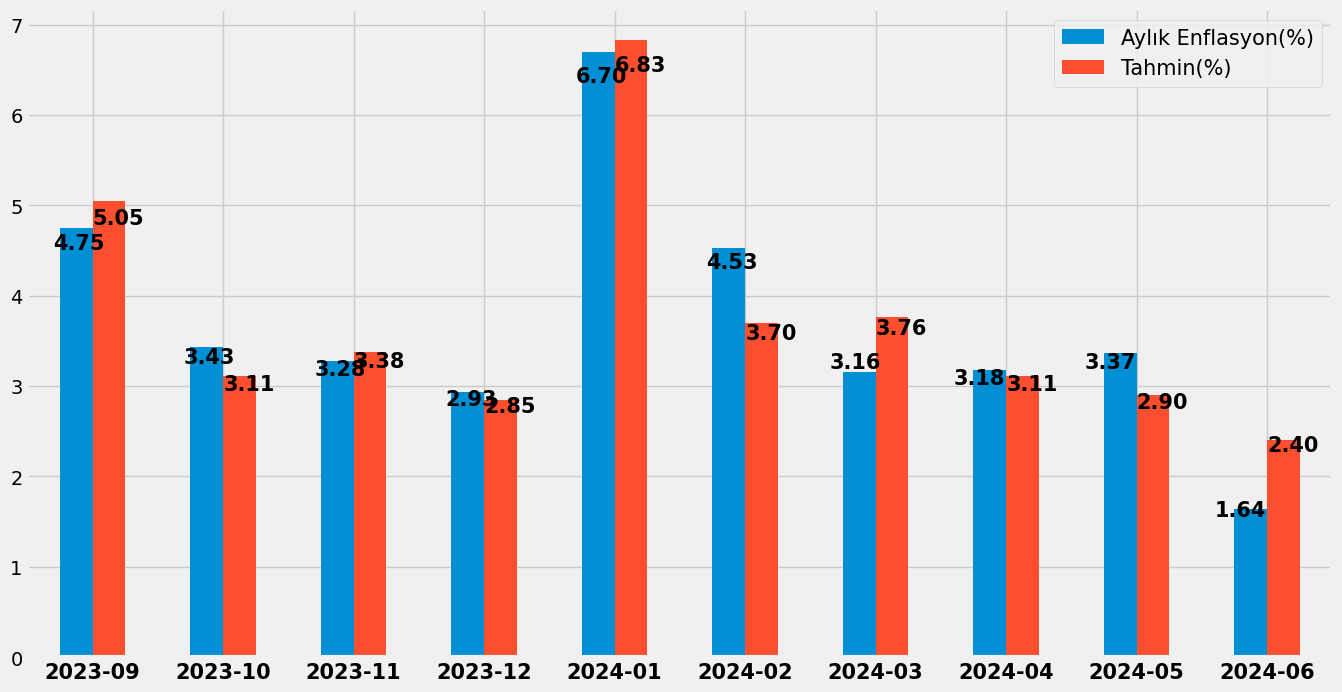

In [ ]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93,6.70,4.53,3.16,3.18,3.37,1.64],"Tahmin(%)":[5.05,3.11,3.38,2.85,6.83,3.70,3.76,3.11,2.90,2.40]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=10,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(15,8))
plt.annotate("4.75",xy=(-0.3,gecmis.iloc[0,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,gecmis.iloc[0,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.7,gecmis.iloc[1,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,gecmis.iloc[1,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.7,gecmis.iloc[2,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,gecmis.iloc[2,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.7,gecmis.iloc[3,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,gecmis.iloc[3,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.70",xy=(3.7,gecmis.iloc[4,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.83",xy=(4,gecmis.iloc[4,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("4.53",xy=(4.7,gecmis.iloc[5,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.70",xy=(5,gecmis.iloc[5,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.16",xy=(5.65,gecmis.iloc[6,1]*0.85),fontweight="bold",fontsize=15)
plt.annotate("3.76",xy=(6,gecmis.iloc[6,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.18",xy=(6.6,gecmis.iloc[7,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(7,gecmis.iloc[7,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.37",xy=(7.6,gecmis.iloc[8,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.90",xy=(8,gecmis.iloc[8,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("1.64",xy=(8.6,gecmis.iloc[9,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.40",xy=(9,gecmis.iloc[9,1]*0.95),fontweight="bold",fontsize=15)

plt.legend(fontsize=15)
plt.xticks(rotation=0,fontweight="bold",fontsize=15,color="black")

In [115]:
aylıktahmin=modelaylık["Ortalama"]
aylıktahmin=aylıktahmin.loc[:"2025-07-31"]

Text(11.75, 1.7079183265370668, '1.79')

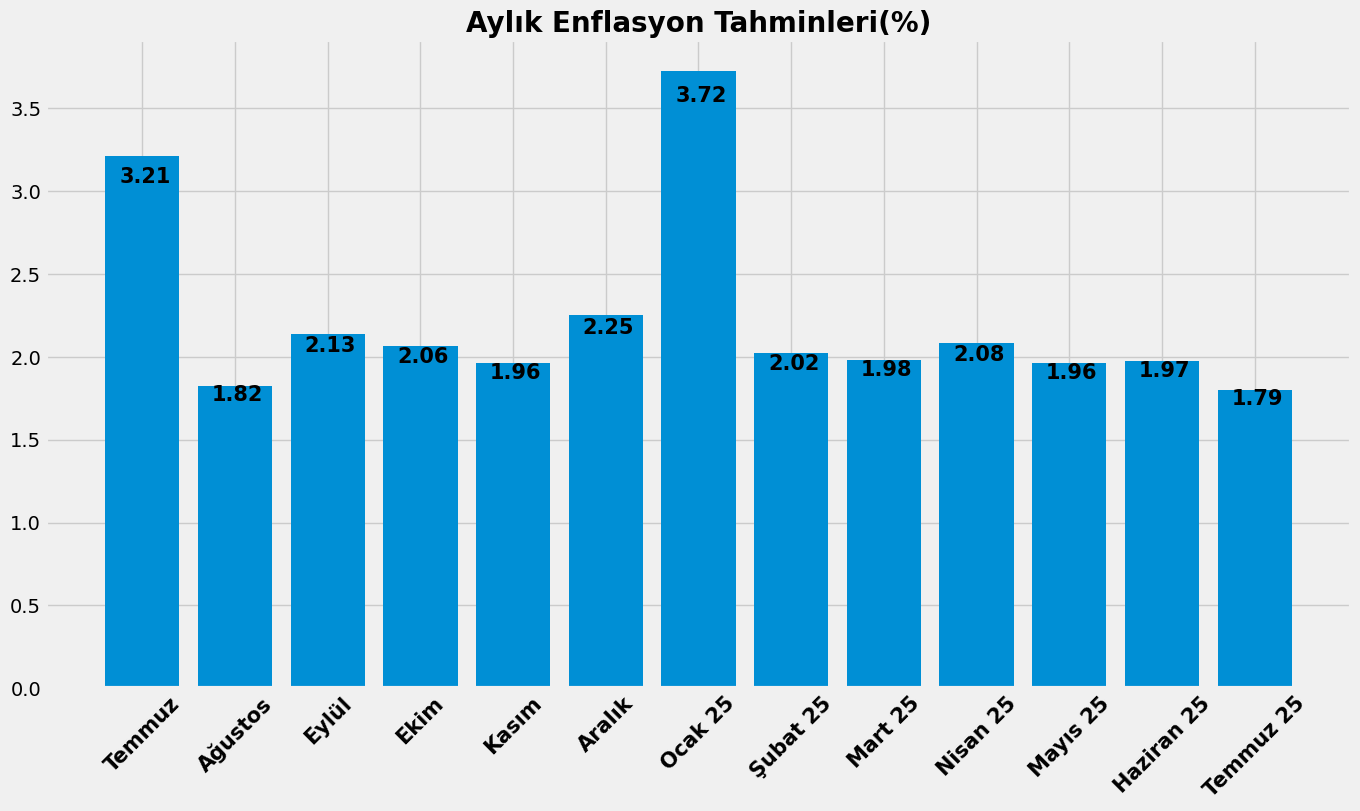

In [116]:
plt.figure(figsize=(15,8))
plt.bar(x=["Temmuz","Ağustos","Eylül","Ekim","Kasım","Aralık","Ocak 25","Şubat 25","Mart 25","Nisan 25","Mayıs 25","Haziran 25","Temmuz 25"],height=aylıktahmin.values)
plt.xticks(rotation=45,fontweight="bold",color="black",fontsize=15)
plt.title("Aylık Enflasyon Tahminleri(%)",fontweight="bold",fontsize=20)
plt.annotate(str(aylıktahmin.iloc[0])[:4],xy=(-0.25,aylıktahmin.iloc[0]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[1])[:4],xy=(0.75,aylıktahmin.iloc[1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[2])[:4],xy=(1.75,aylıktahmin.iloc[2]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[3])[:4],xy=(2.75,aylıktahmin.iloc[3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[4])[:4],xy=(3.75,aylıktahmin.iloc[4]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[5])[:4],xy=(4.75,aylıktahmin.iloc[5]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[6])[:4],xy=(5.75,aylıktahmin.iloc[6]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[7])[:4],xy=(6.75,aylıktahmin.iloc[7]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[8])[:4],xy=(7.75,aylıktahmin.iloc[8]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[9])[:4],xy=(8.75,aylıktahmin.iloc[9]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[10])[:4],xy=(9.75,aylıktahmin.iloc[10]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[11])[:4],xy=(10.75,aylıktahmin.iloc[11]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[12])[:4],xy=(11.75,aylıktahmin.iloc[12]*0.95),fontweight="bold",fontsize=15)



